# Test on MNIST dataset

In [1]:
%load_ext autoreload
%autoreload 2

from scripts.benchmark_functions import *
from scripts.train_functions import set_up_model
from mnist_demo.utils import *
import scod
import copy
import random

#### Load trained model

In [2]:
load_model_path = './best_model/mnist_model.pt'
model, optimizer, start_epoch_idx, valid_loss, criterion, device = load_model_from_ckp(load_model_path)

/home/somrita/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


#### Evaluate trained model on 5 MNIST digits (drawn from mnist_test) and Fashion (drawn from fashion)

In [3]:
batch_size = 256
dataset_name = "mnist"

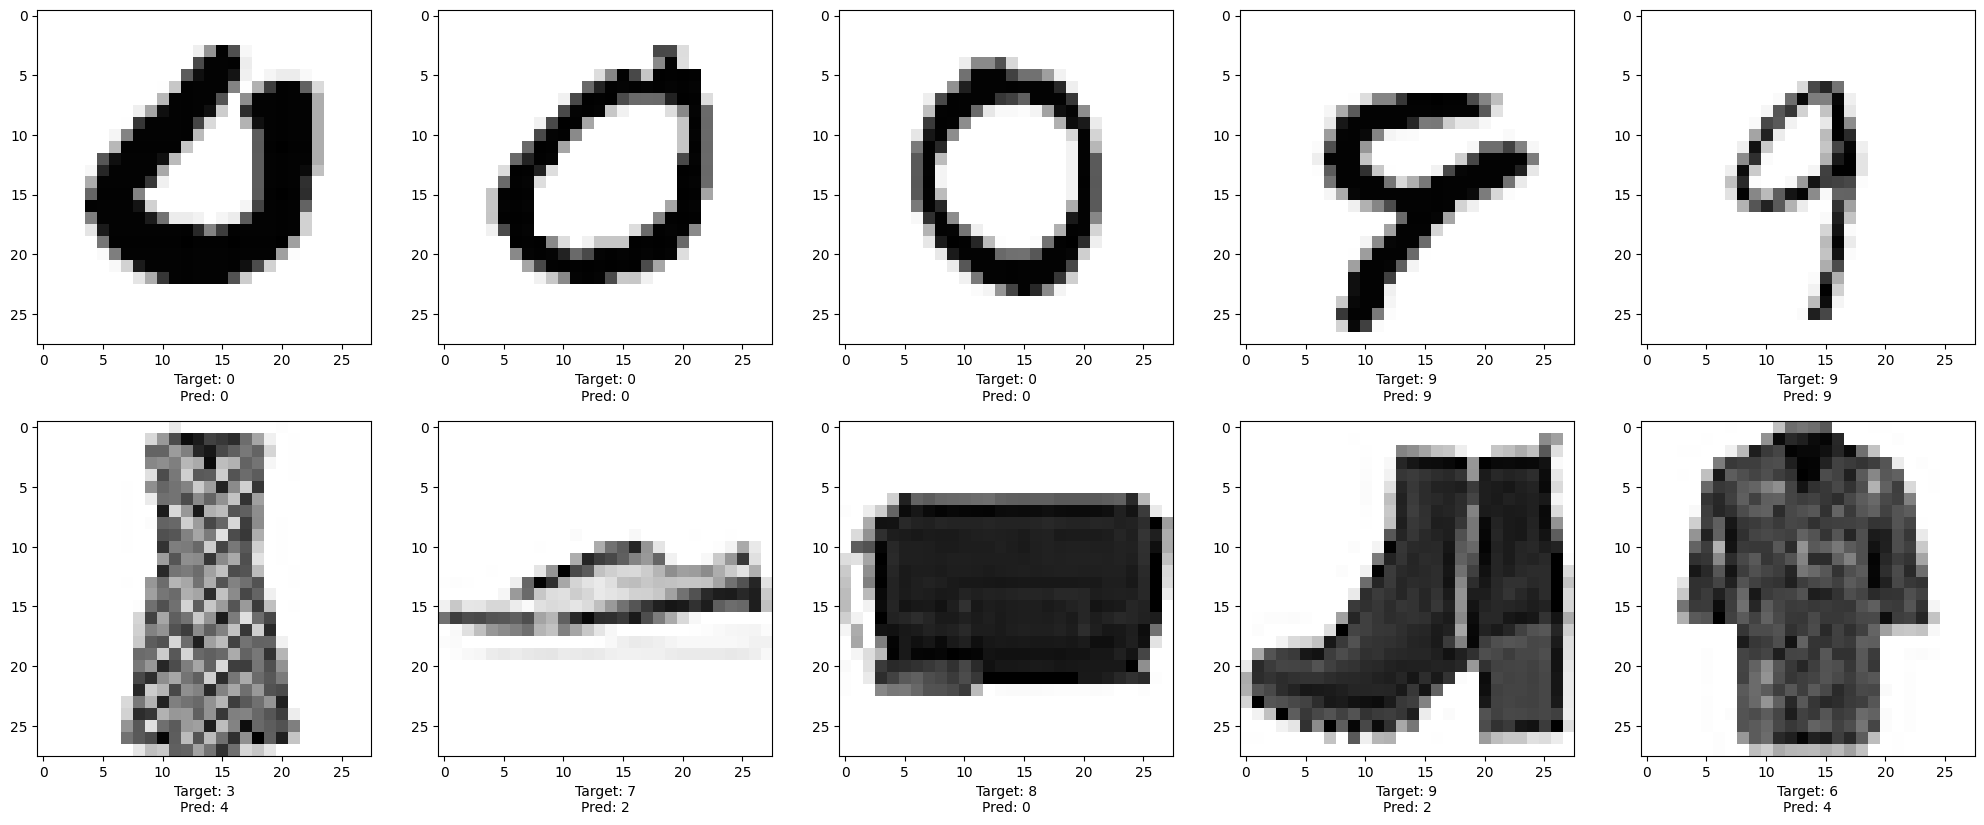

In [4]:
dataloaders, dataset_sizes = create_dataloaders('', batch_size, dataset_name = dataset_name)

num_plots = 5
datasets_to_viz = [dataloaders['mnist_test'].dataset, dataloaders['fashion'].dataset]
num_datasets = len(datasets_to_viz)
fig, axes = plt.subplots(num_datasets,num_plots, figsize=[5*num_plots, 5*num_datasets], dpi=100, squeeze=False)
np.random.seed(seed=42)
for di, dataset in enumerate(datasets_to_viz):
    for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
        viz_dataset_sample( axes[di][j], dataset, idx , model=model)

#### Add SCOD wrapper

In [5]:
unc_model = create_scod_model(load_model_path, dataset_name, batch_size)

Weight space dimension: 4.443e+04
computing basis
using T = 304


  0%|          | 0/188 [00:00<?, ?it/s]

/home/somrita/anaconda3/lib/python3.7/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


#### Print SCOD uncertainties for MNIST digits

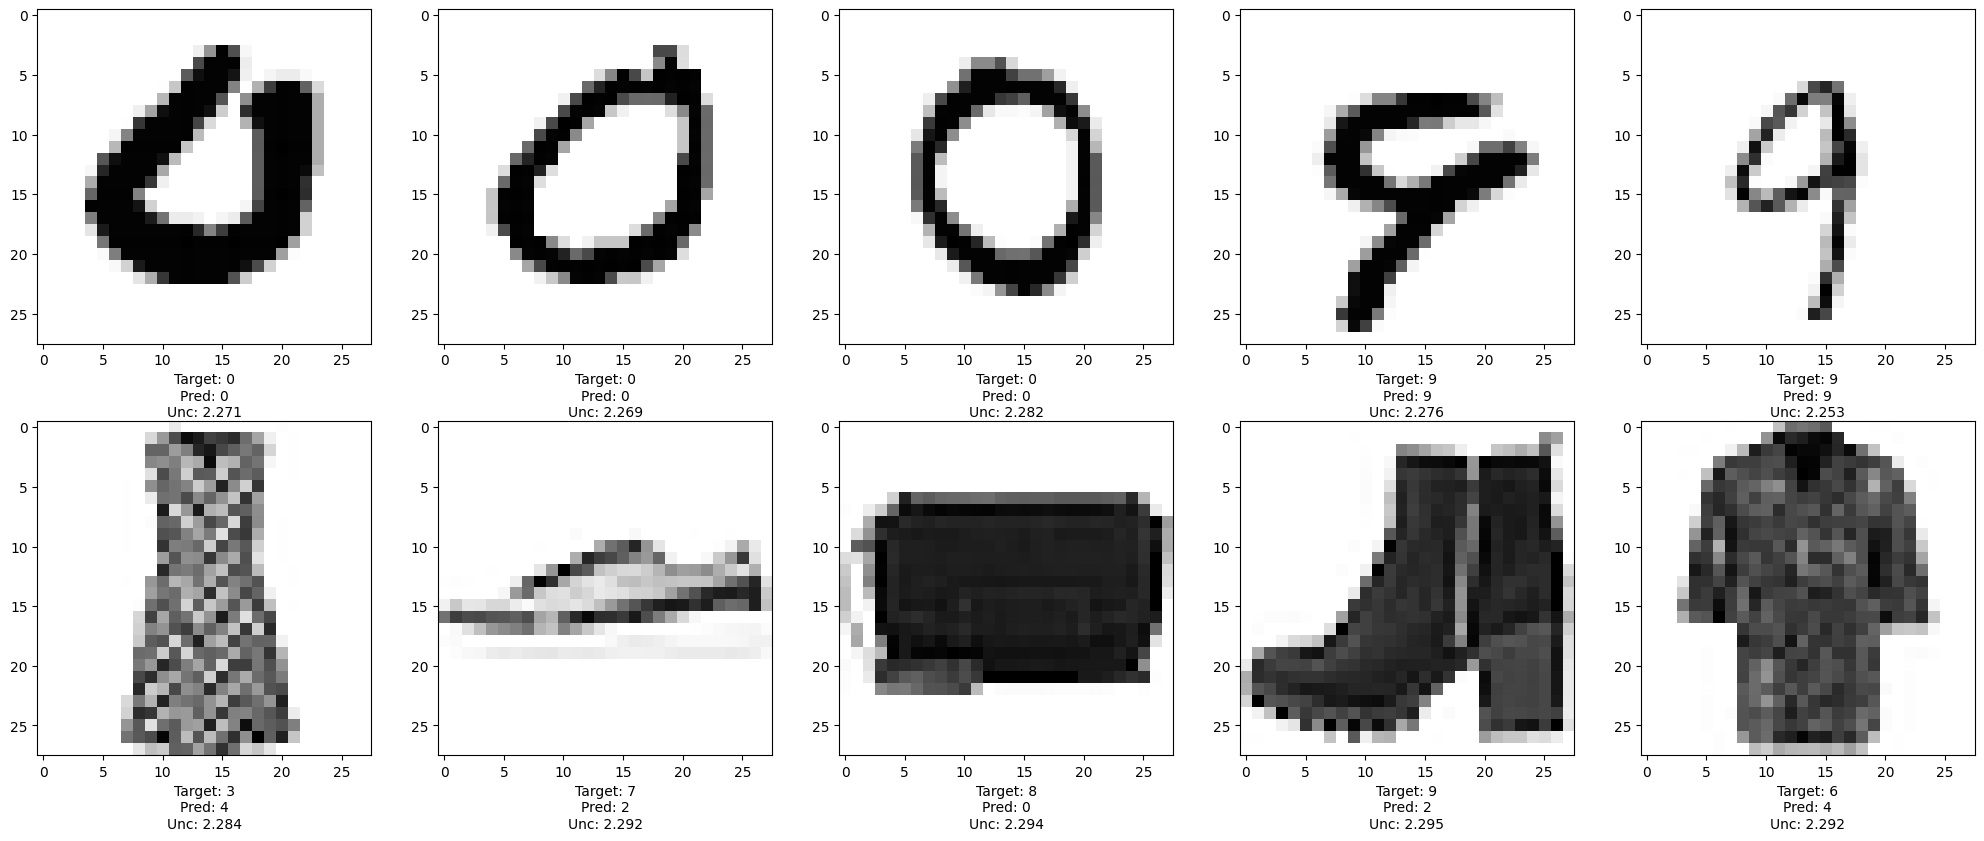

In [6]:
dataloaders, dataset_sizes = create_dataloaders('', batch_size, dataset_name = dataset_name)

num_plots = 5
datasets_to_viz = [dataloaders['mnist_test'].dataset, dataloaders['fashion'].dataset]
num_datasets = len(datasets_to_viz)
fig, axes = plt.subplots(num_datasets,num_plots, figsize=[5*num_plots, 5*num_datasets], dpi=100, squeeze=False)
np.random.seed(seed=42)
for di, dataset in enumerate(datasets_to_viz):
    for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
        viz_dataset_sample( axes[di][j], dataset, idx , model=model, unc_model=unc_model)

Question: Can SCOD detect the out-of-distribution images here?

#### ANSWER: Yes.

# Plot classification accuracy vs scod uncertainty

In [7]:
dataloaders, dataset_sizes = create_dataloaders('', batch_size, dataset_name = dataset_name)

images = {'mnist_test':100, 'fashion':100}
images = {'mnist_test':100, 'emnist':100, 'fashion':100}

accs = {}
uncs = {}
losses = {}
np.random.seed(seed=11)
for dname in images:
    accs[dname] = np.zeros(images[dname])
    uncs[dname] = np.zeros(images[dname])
    losses[dname] = np.zeros(images[dname])
    idxs = np.random.choice(len(dataloaders[dname].dataset), images[dname])
    for i, idx in enumerate(idxs):
        input, target = (dataloaders[dname].dataset)[idx]
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if unc_model is not None:
            z_mean, z_var = unc_model(input.to(device).unsqueeze(0))
            pred = np.argmax(z_mean[0].detach().cpu().numpy())

            dist_layer = scod.distributions.CategoricalLogitLayer()
            unc = eval_scod(input, unc_model, dist_layer)
            unc = unc.item()

            accs[dname][i] = (pred==target)
            uncs[dname][i] = unc
        if model is not None:
            output = model(input.to(device).unsqueeze(0))
            dist = dist_layer(output.to(device))
            if target > 9:
                target = 9
            loss = -dist.log_prob(torch.tensor(target).to(device))
            mean_loss = loss.mean().item()
            losses[dname][i] = mean_loss


Text(0, 0.5, 'Losses')

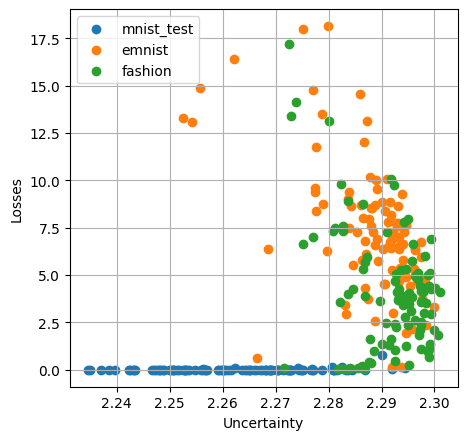

In [8]:
fig, axes = plt.subplots(1,1, figsize = [5,5], dpi = 100)
ax = axes
for dname in images:
    ax.scatter(uncs[dname], losses[dname], label=dname)
ax.legend()
ax.grid()
ax.set_xlabel('Uncertainty')
ax.set_ylabel('Losses')

Text(0.5, 0, 'Losses')

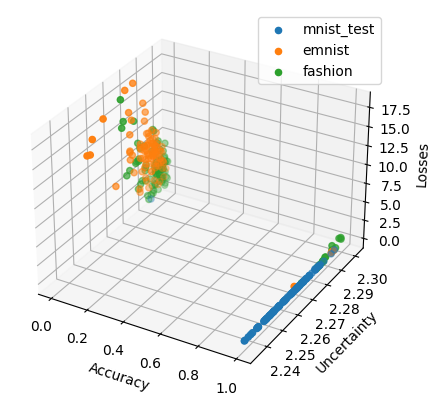

In [9]:
fig = plt.figure(figsize = [5,5], dpi=100)
ax = fig.add_subplot(projection='3d')
for dname in images:
    ax.scatter(accs[dname], uncs[dname], losses[dname], label=dname)
ax.legend()
ax.grid()
ax.set_xlabel('Accuracy')
ax.set_ylabel('Uncertainty')
ax.set_zlabel('Losses')

Text(0, 0.5, 'Uncertainty')

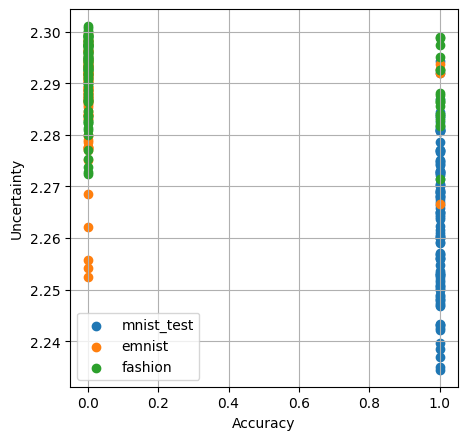

In [10]:
fig, axes = plt.subplots(1,1, figsize = [5,5], dpi = 100)
ax = axes
for dname in images:
    ax.scatter(accs[dname], uncs[dname], label=dname)
ax.legend()
ax.grid()
ax.set_xlabel('Accuracy')
ax.set_ylabel('Uncertainty')

Text(0, 0.5, 'Losses')

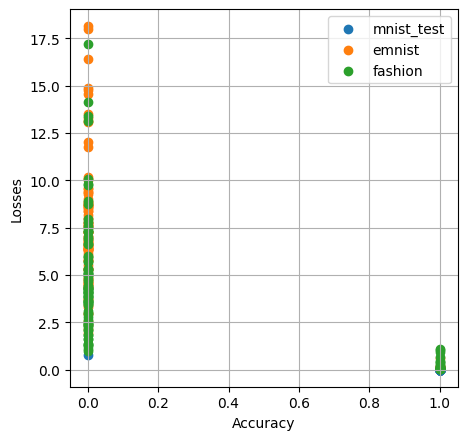

In [11]:
fig, axes = plt.subplots(1,1, figsize = [5,5], dpi = 100)
ax = axes
for dname in images:
    ax.scatter(accs[dname], losses[dname], label=dname)
ax.legend()
ax.grid()
ax.set_xlabel('Accuracy')
ax.set_ylabel('Losses')

#### From a batch of mixed fashion + mnist, use scod-k highest and DS-SCOD to pull out 2 images to label

In [95]:
batch_size = 10
batch_compositions = [  {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5},
                        {'mnist_test':5,'fashion':5}
                        ]
# batch_compositions = [  {'mnist_test':5,'fashion':5}
#                         ]
num_batches = len(batch_compositions)

flag_limit = 2
algs_to_test = [lambda x: scod_flagger(x, unc_model, flag_limit=flag_limit, debug = False, dist_layer = scod.distributions.CategoricalLogitLayer()),
                lambda x: ds_scod_flagger(x, unc_model, flag_limit, debug=False, dist_layer = scod.distributions.CategoricalLogitLayer())]

Test seq  0  algorithm  0  flagged:  [False, False, False, False, False, False, True, False, True, False]
Test seq  0  algorithm  1  flagged:  [False, False, False, False, False, True, False, False, True, False]
Test seq  1  algorithm  0  flagged:  [False, False, False, False, False, True, False, True, False, False]
Test seq  1  algorithm  1  flagged:  [False, False, False, False, False, False, True, False, False, True]
Test seq  2  algorithm  0  flagged:  [False, False, False, False, False, True, True, False, False, False]
Test seq  2  algorithm  1  flagged:  [False, False, False, False, False, True, False, False, False, True]
Test seq  3  algorithm  0  flagged:  [False, False, False, False, False, False, True, False, False, True]
Test seq  3  algorithm  1  flagged:  [False, False, False, False, False, True, True, False, False, False]
Test seq  4  algorithm  0  flagged:  [False, False, False, False, False, False, True, True, False, False]
Test seq  4  algorithm  1  flagged:  [False, F

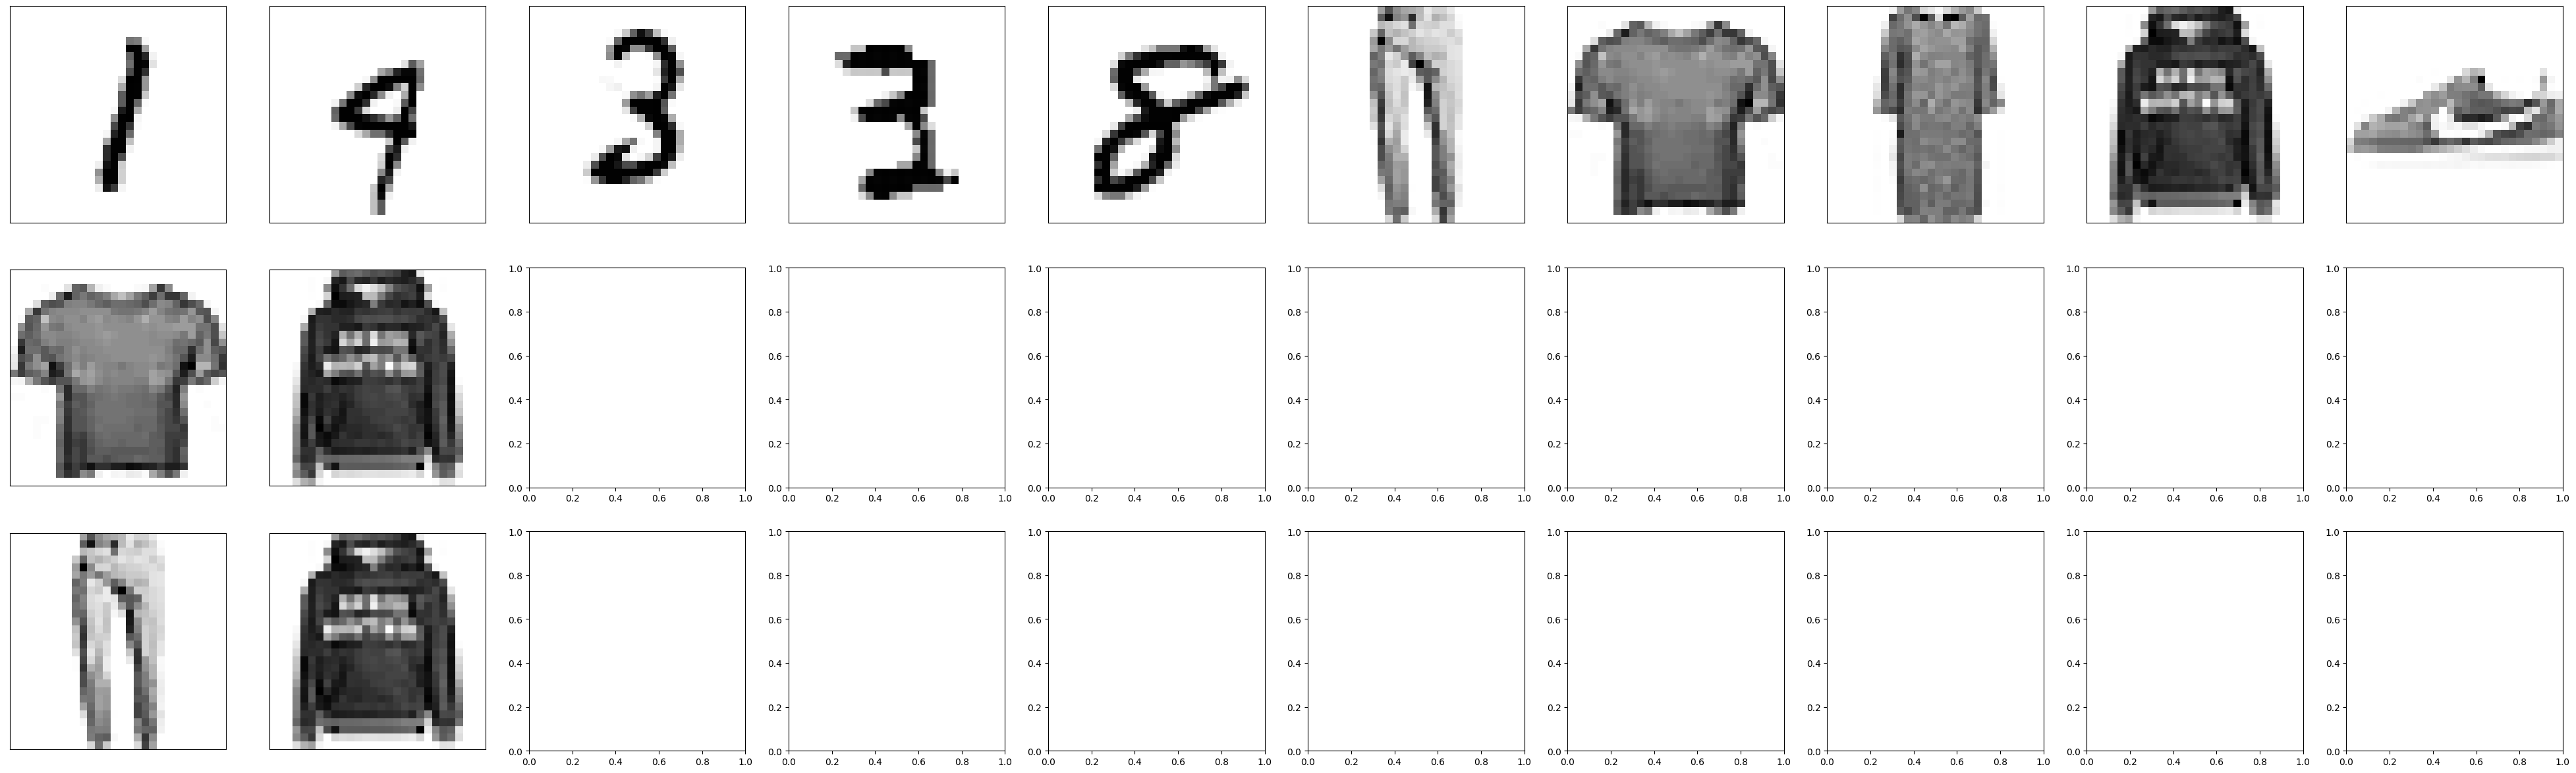

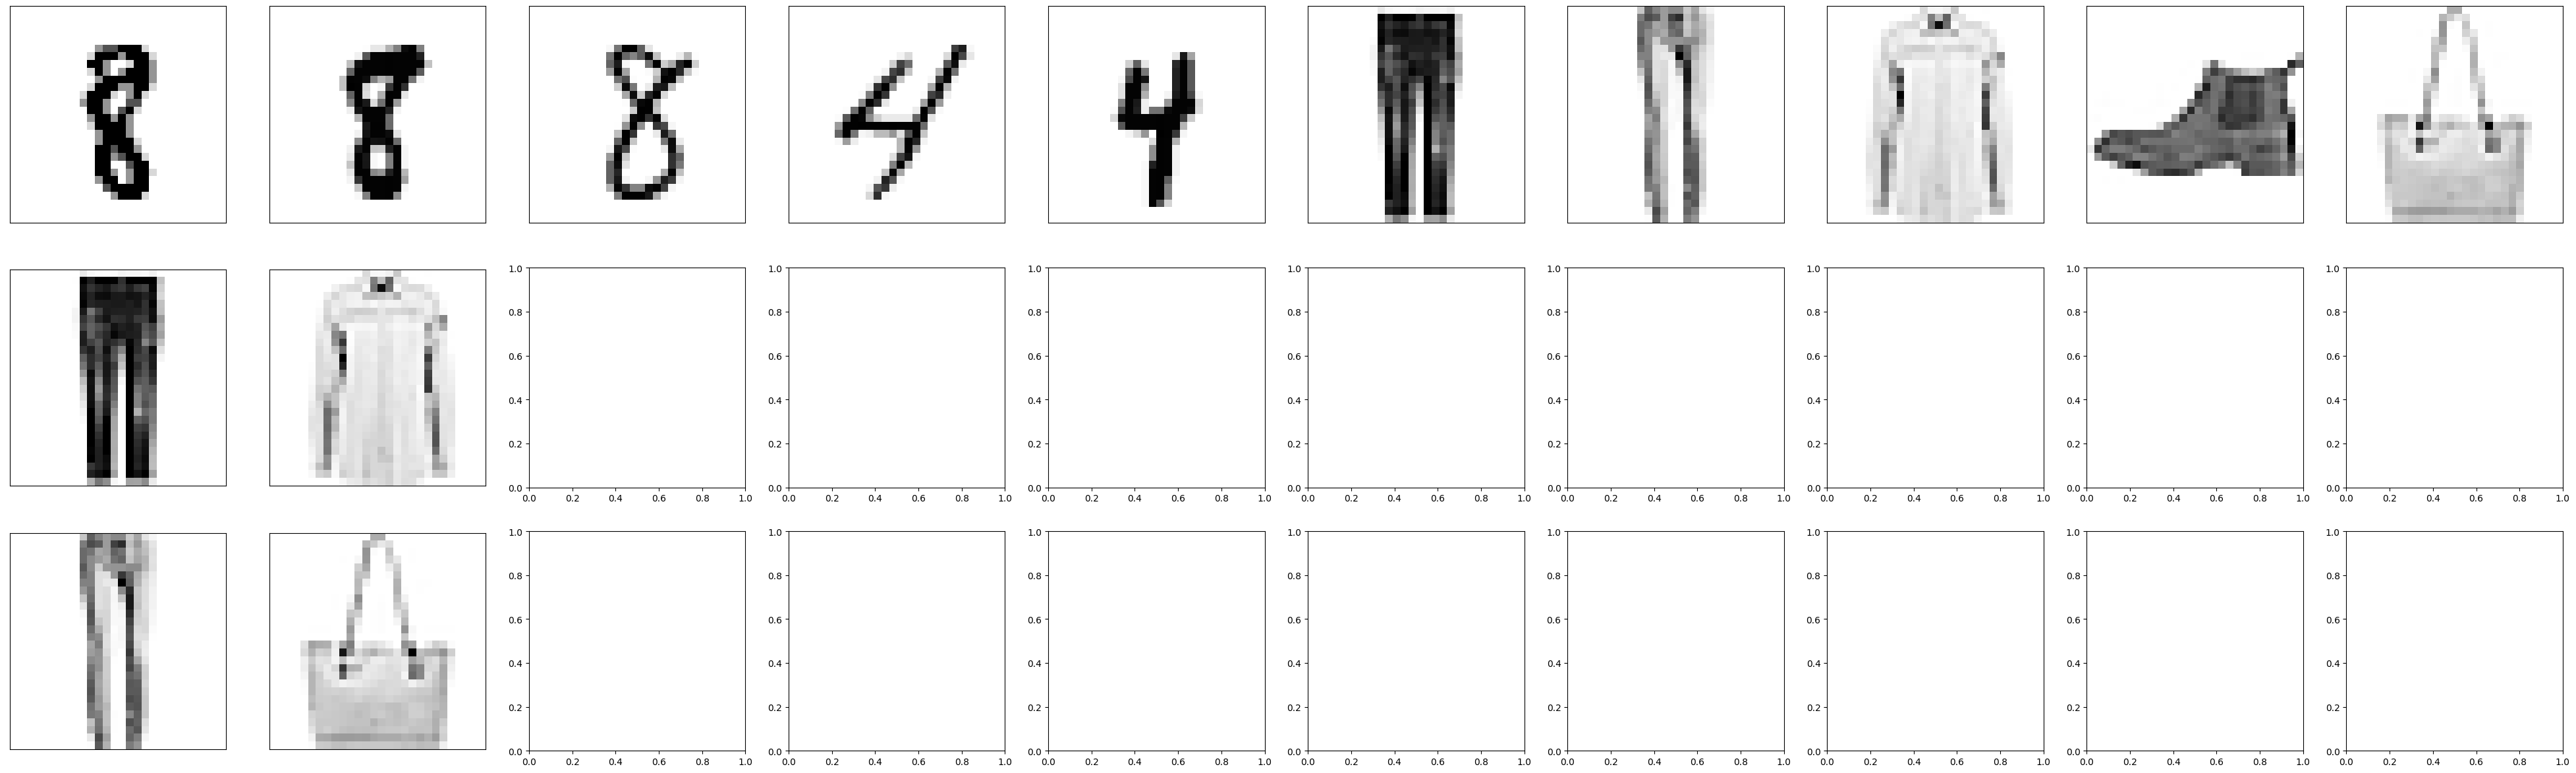

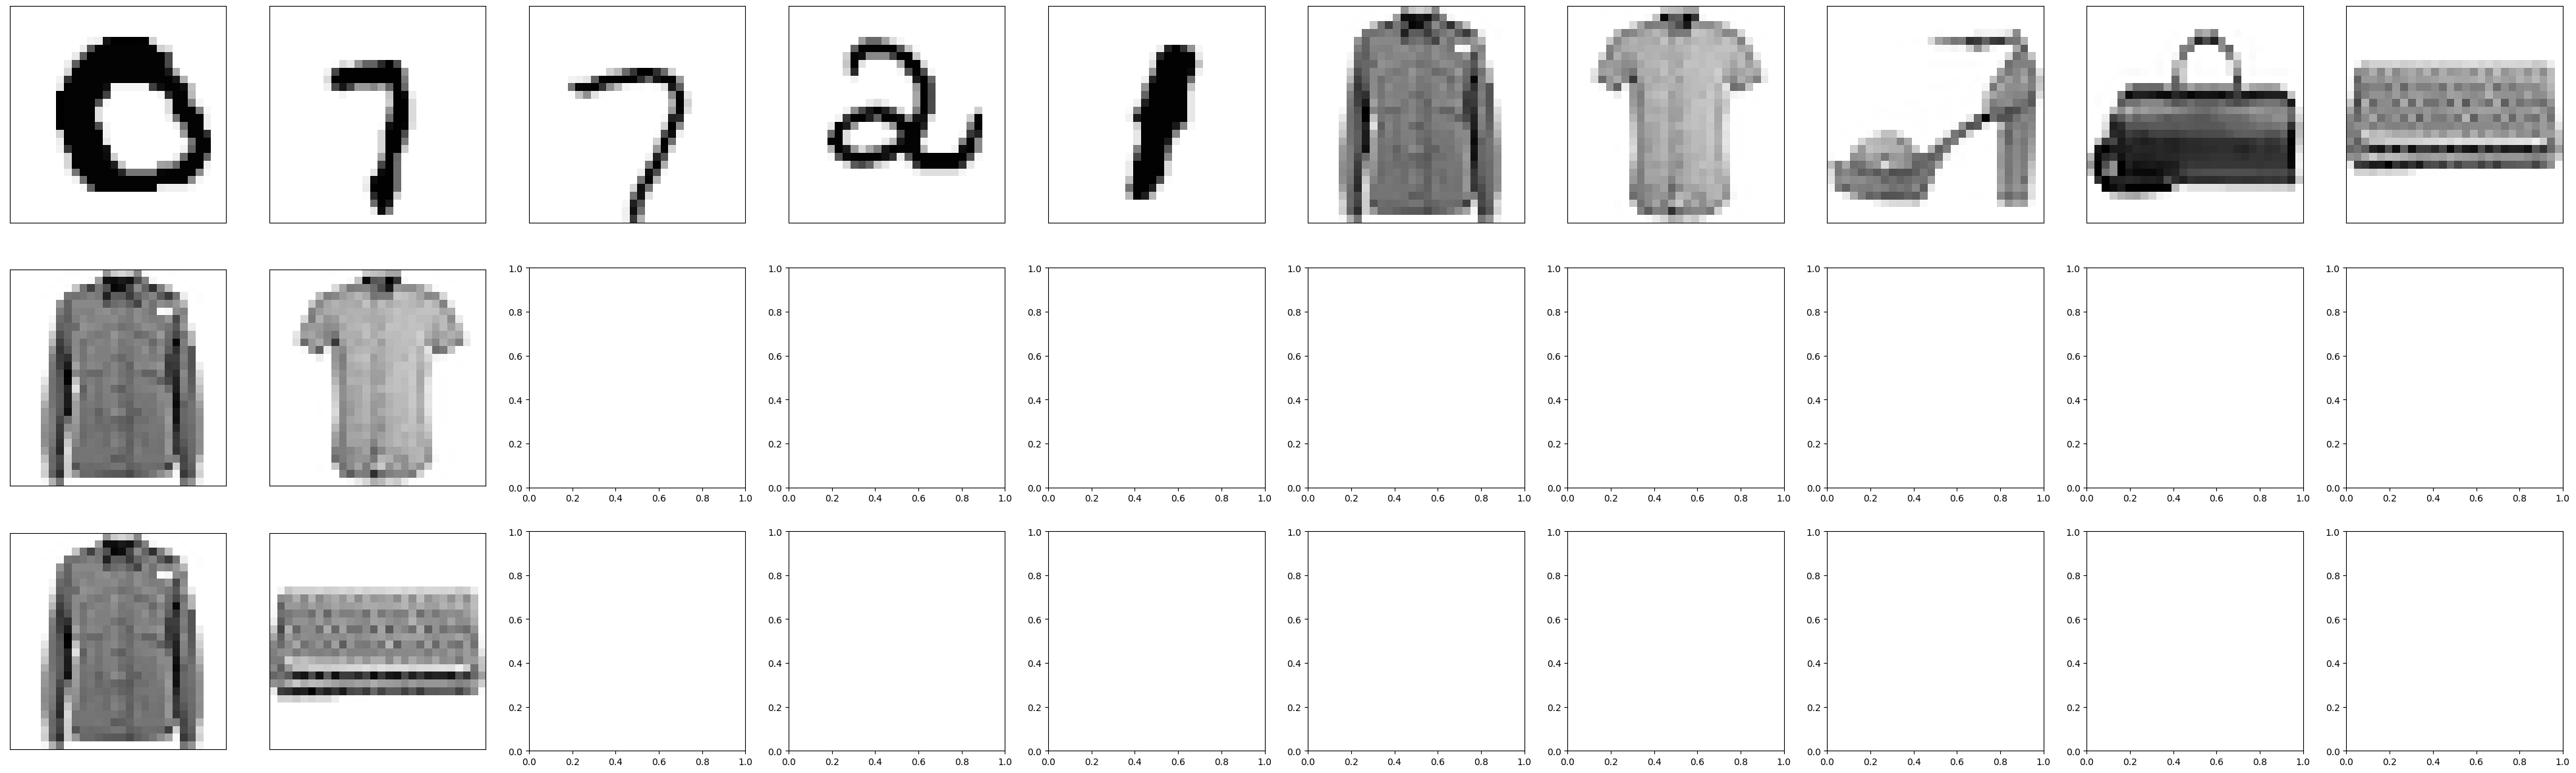

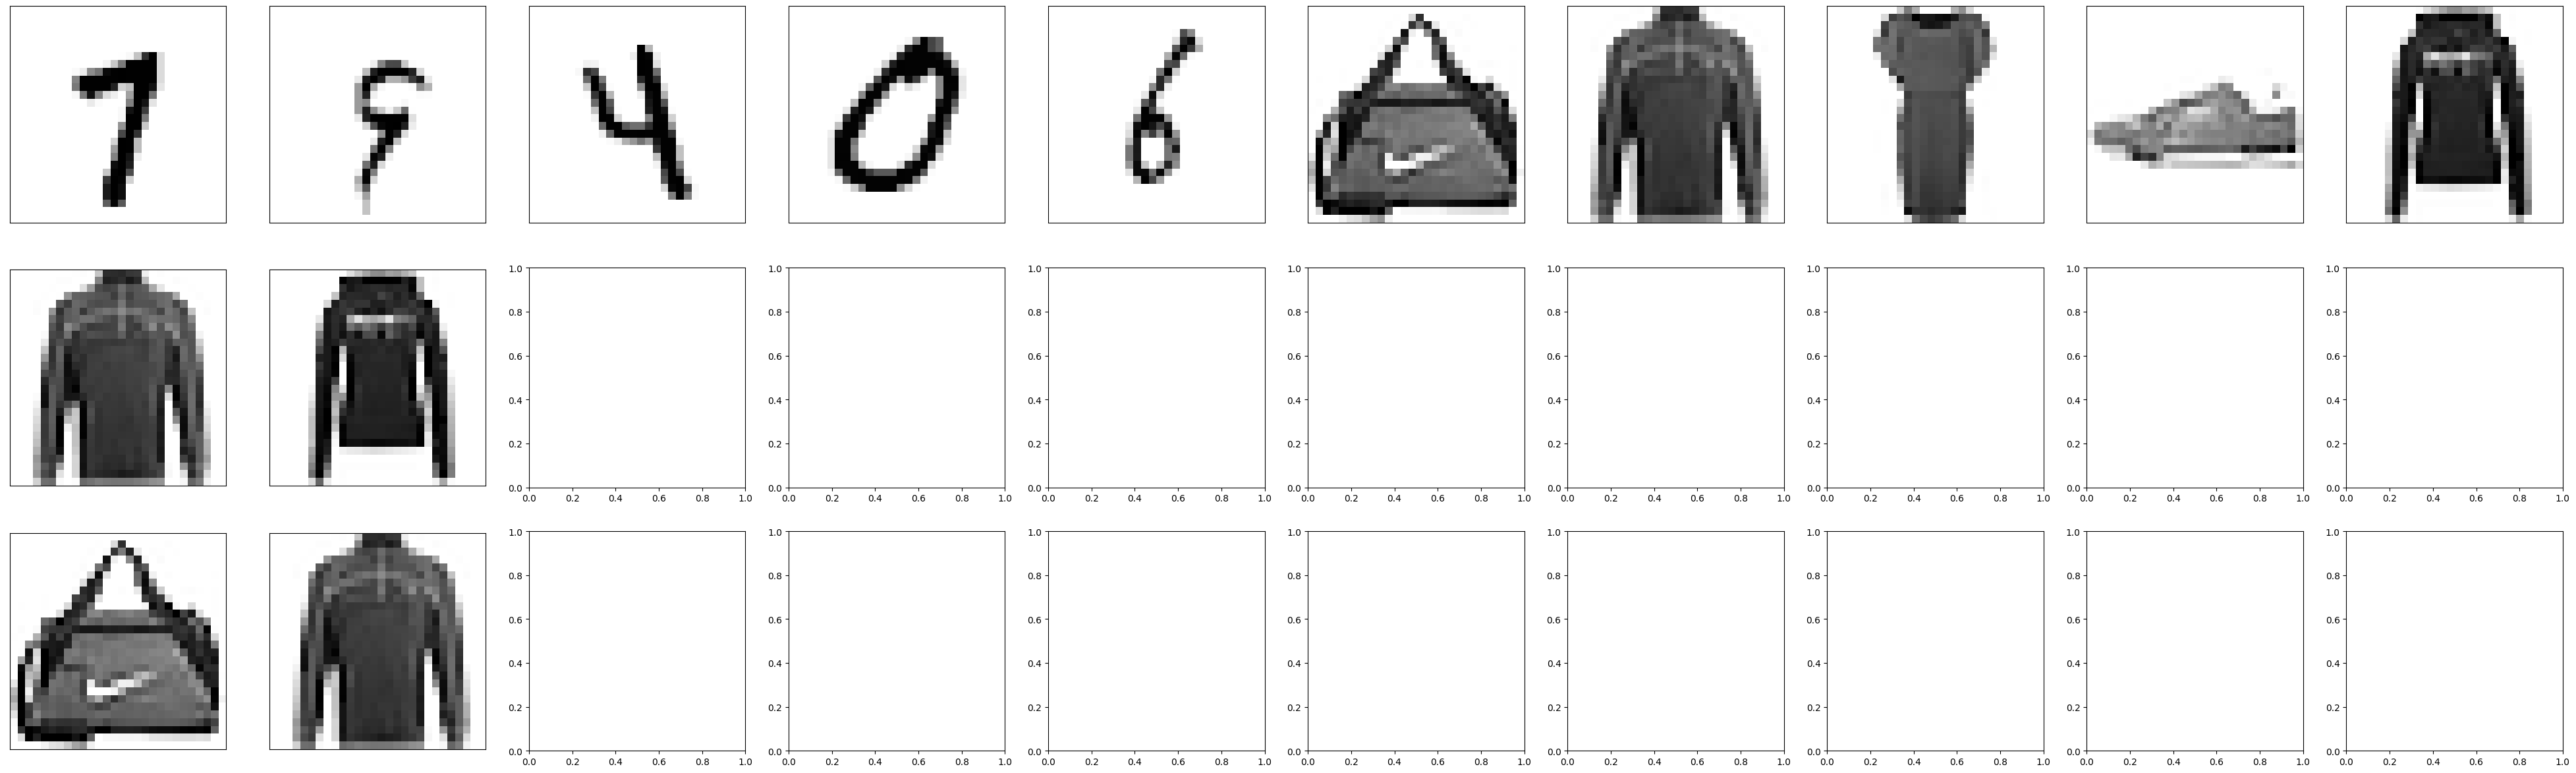

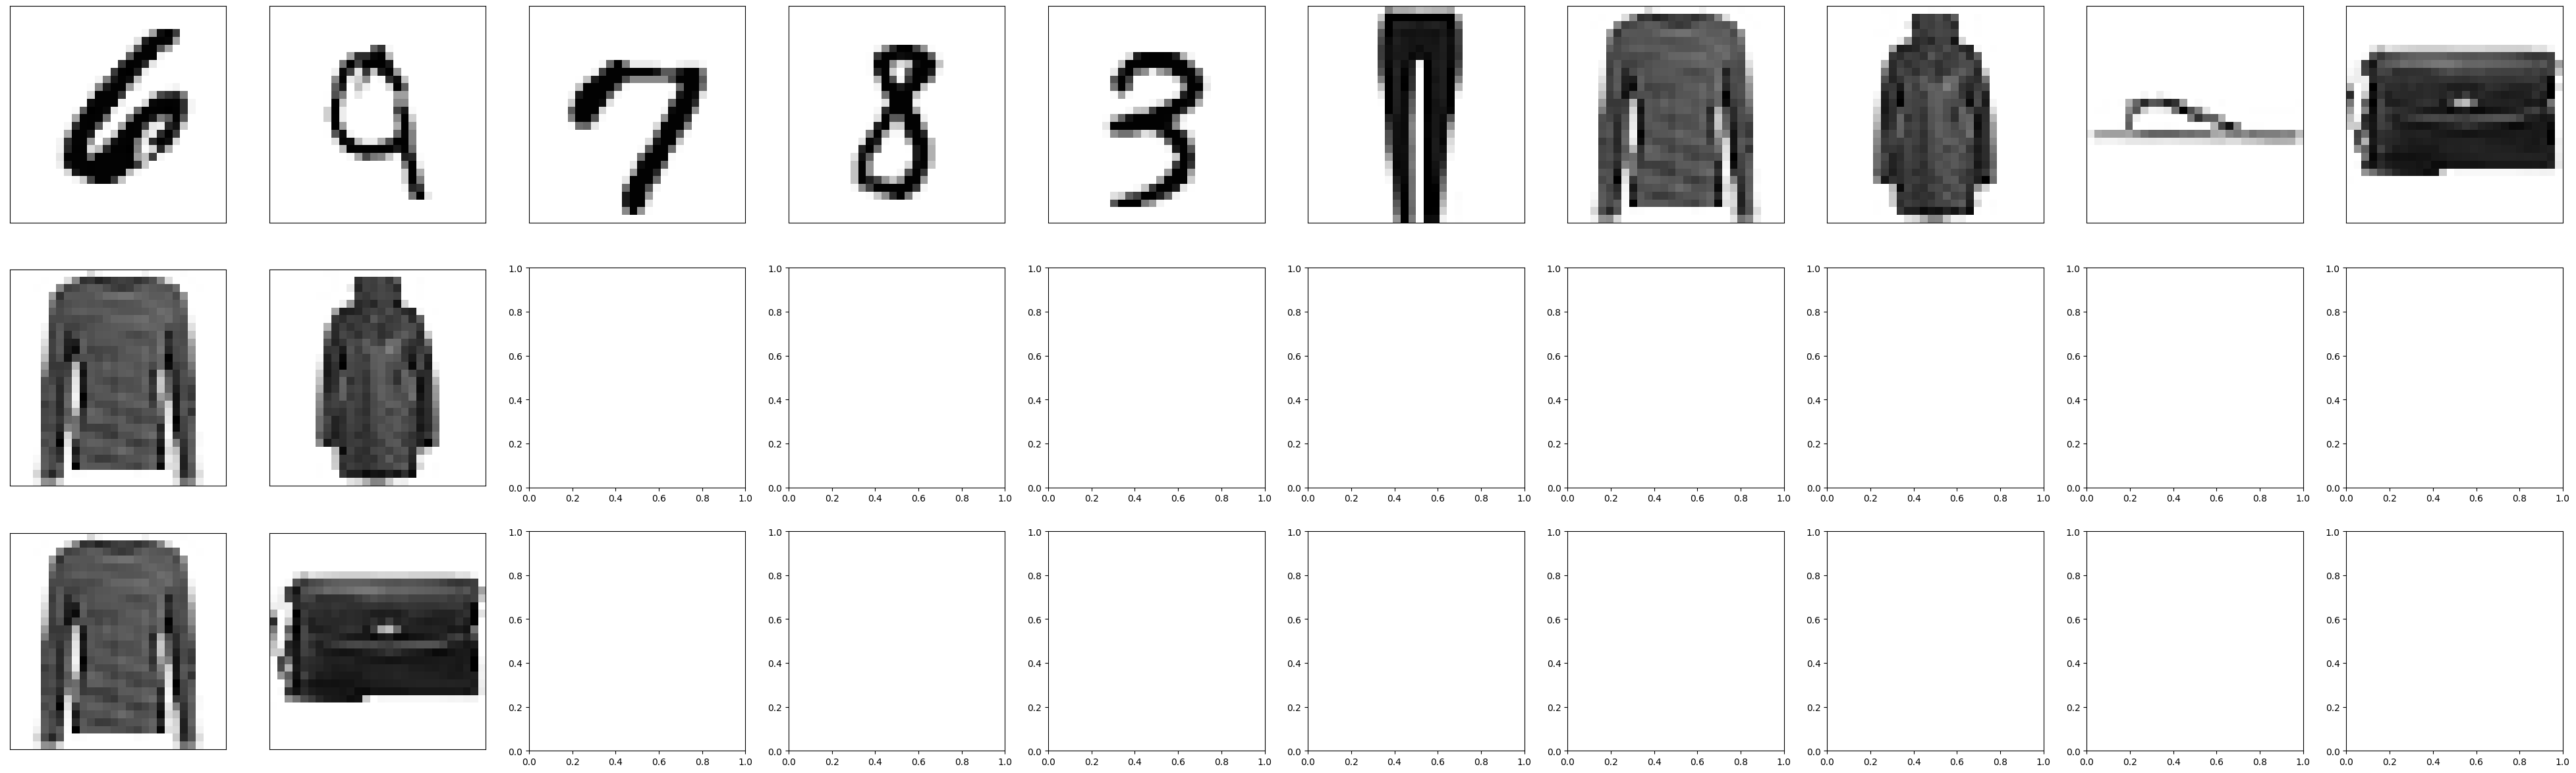

In [96]:
test_seq, labels, fnames, flags = alg_flags(algs_to_test, dataset_name, batch_size, num_batches, batch_compositions)
for i in range(num_batches):
    fig, axes = plt.subplots(len(algs_to_test)+1, batch_size, figsize=[5*batch_size, 5*(len(algs_to_test)+1)], dpi=100, squeeze=False)
    # Plot the full batch
    for j,ts in enumerate(test_seq[i]):
        plt_image(axes[0,j], ts)
    # Plot the subsampled points
    for k in range(len(algs_to_test)):
        ts_subset = [ts for (ts,flg) in zip(test_seq[i], flags[i][k]) if flg]
        for m,ts in enumerate(ts_subset):
            plt_image(axes[k+1,m], ts)



TODO:
1. From a batch, show subselection using SCOD-k highest and DS-SCOD 
1a If this doesn't show semantic diversity, try adding emnist
1b. Create figure
2. have mnist scripts and notebooks in a separate folder. Add src folder?
3. Then, see if training improves performance (accuracy) of model at all?

1. Take a mixed batch (90% normal test, 10% fashion)\
Detect the 10% that is OOD using SCOD k-highest

2. Mix this 10% with another 10% from old images (train)\
Train on the mixture for N epochs (plot loss curve)

3. Plot the loss/accuracy/scod uncertainty for a validation set of [fashion; normal test]

4. Repeat steps 1-3 for X batches

In [12]:
num_batches = 1
batch_size = 100
ood_ratio = 0.1
mix_train_ratio = 0.01
lr = 0.1
num_epochs = 10
verbose = True

ood_num = int(batch_size*ood_ratio)
mix_train_num = int(batch_size*mix_train_ratio)
batch_compositions = [  {'mnist_test':batch_size - ood_num,'fashion':ood_num}]*num_batches
train_batch_compositions = [{'mnist_train':mix_train_num}]*num_batches

flag_limit = ood_num
algs_to_test = [lambda x: scod_flagger(x, unc_model, flag_limit=flag_limit, debug = False, dist_layer = scod.distributions.CategoricalLogitLayer())]

test_seq, labels, fnames, flags = alg_flags(algs_to_test, dataset_name, batch_size, num_batches, batch_compositions)
train_subset, train_labels, train_fnames = create_benchmark_seq_batches(dataset_name, mix_train_num, num_batches, train_batch_compositions)
for i in range(num_batches):
    for k in range(len(algs_to_test)):
        flagged_subset = [(ts, lbl) for (ts,lbl,flg) in zip(test_seq[i], labels[i], flags[i][k]) if flg]
        train_subset = [(ts, lbl) for (ts,lbl) in zip(train_subset[i], train_labels[i])]
        verbose and print("flagged subset length: ", len(flagged_subset), " \n")
        verbose and print("train subset length: ", len(train_subset), " \n")
        verbose and print("train labels: ", [ts[1] for ts in train_subset])
        refine_subset = flagged_subset + train_subset
        random.shuffle(refine_subset)
        verbose and print("all labels: ", [rs[1] for rs in refine_subset])
        # verbose and print("all inputs: ", [rs[0] for rs in refine_subset])
        

        r_model = copy.deepcopy(model)
        _, _, _, criterion, device = set_up_model(dataset_name, spec_lr=lr) # Can be reduced to not overfit
        inputs = torch.stack([rs[0] for rs in refine_subset]).to(device)
        labels = torch.stack([rs[1] for rs in refine_subset]).to(device).float()

        for epoch in range(num_epochs+1):
            verbose and print('Epoch {}/{}'.format(epoch, num_epochs))
            verbose and print('-' * 10)
            r_model.train()
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = r_model(inputs)
                if criterion is None:
                    dist_layer = scod.distributions.CategoricalLogitLayer()
                    dist = dist_layer(outputs)
                    verbose and print("dist: ", dist)
                    prob_loss = -dist.log_prob(labels)
                    mean_loss = prob_loss.mean()
                    verbose and print("epoch: ", epoch, " loss: ", mean_loss)
                    # regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in r_model.parameters()])) / 2e3
                    # loss = mean_loss + regularization
                    loss = mean_loss
                else:
                    loss = criterion(outputs, labels.float().cuda())
                loss.backward()
                optimizer.step()
            current_loss = loss.item() * inputs.size(0)
            verbose and print('Current loss {:.6f}.'.format(current_loss))
        


Test seq  0  algorithm  0  flagged:  [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, False, True, True, True, True, True, True]
flagged subset length:  10  

train subset length:  1  

train labels:  [tensor([4.])]
all labels:  [tensor([5.]), tensor([4.]), tensor([1.]), tensor([0.]), tensor([4.]), tensor([5.]), tensor([4.]), tensor([6.]), tensor([9.]), tensor([7.]), tensor([3.])]
Epoch 0/10
------